# Image-based search engine


----

### Reference:
- ***Blogs***
    - [Image-based search engine](https://huggingface.co/blog/not-lain/image-retriever)
- ***GitHub***
    - .

----

### Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

## Configure device

In [1]:
import torch

if torch.backends.mps.is_available():
    g_device = "mps"
elif torch.cuda.is_available():
    g_device = "cuda"
    !nvidia-smi
else:
    g_device = "cpu"

print(f"Available device : {g_device}")


Thu Sep 18 17:04:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 34%   48C    P5             39W /  250W |    1300MiB /  11264MiB |     43%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Embedding the data

In [2]:
from datasets import load_dataset
dataset = load_dataset("not-lain/pokemon",split="train")

In [3]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 898
})

In [4]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification # or you can use CLIPProcessor, CLIPModel

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14", device_map = g_device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
def embed(batch):
    pixel_values = processor(images = batch["image"], return_tensors="pt")['pixel_values']
    pixel_values = pixel_values.to(g_device)
    img_emb = model.get_image_features(pixel_values)
    batch["embeddings"] = img_emb.to('cpu')
    return batch

embedded_dataset = dataset.map(embed, batched=True, batch_size=4)

Map:   0%|          | 0/898 [00:00<?, ? examples/s]

In [6]:
dataset = embedded_dataset.add_faiss_index("embeddings")

  0%|          | 0/1 [00:00<?, ?it/s]

## Retrieve images

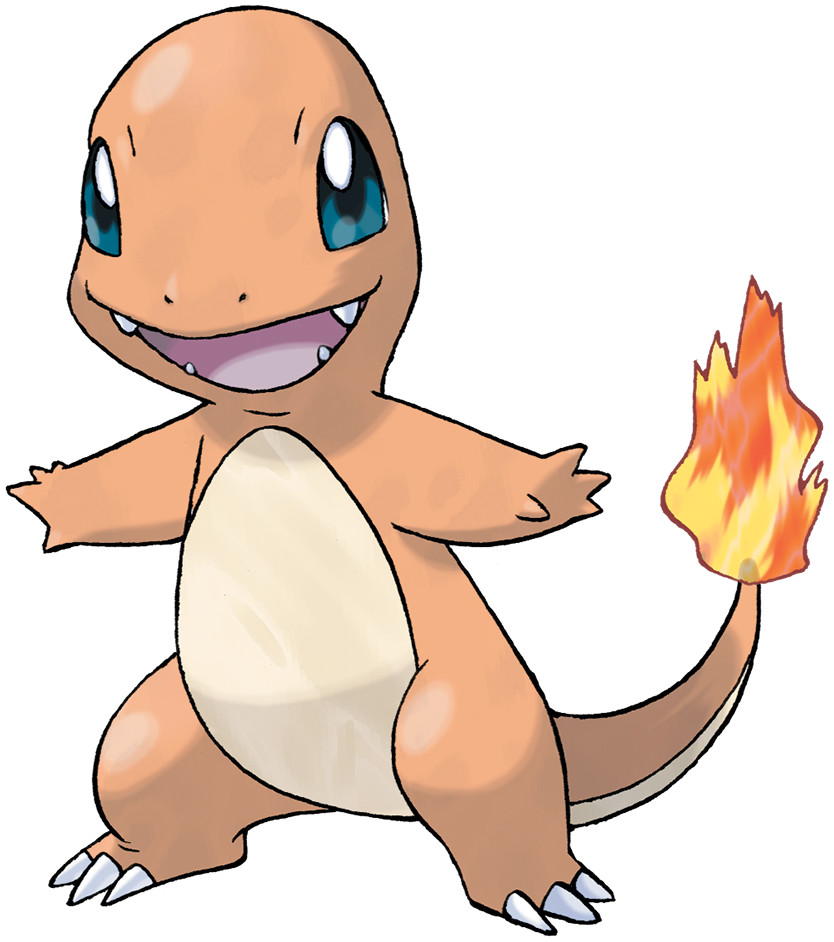

In [7]:
from loadimg import load_img
image = load_img("https://img.pokemondb.net/artwork/large/charmander.jpg")
image

In [10]:
import numpy as np

def search(query: str, k: int = 4 ):
    """a function that embeds a new image and returns the most probable results"""

    pixel_values = processor(images = query, return_tensors="pt")['pixel_values'] # embed new query
    pixel_values = pixel_values.to(g_device)
    img_emb = model.get_image_features(pixel_values)[0] # because 1 element
    img_emb = img_emb.cpu().detach().numpy()

    scores, retrieved_examples = dataset.get_nearest_examples( # retrieve results
        "embeddings", img_emb, # compare our new embedded query with the dataset embeddings
        k=k # get only top k results
    )

    return retrieved_examples

In [11]:
retrieved_examples = search(image, k=4)

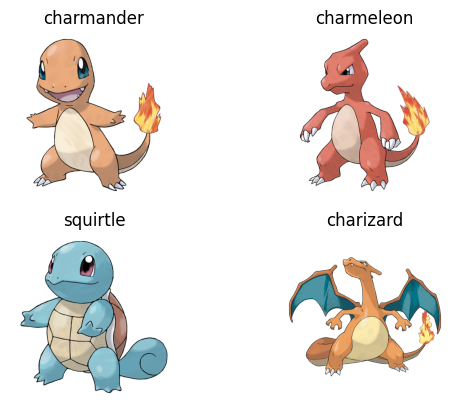

In [12]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2,2)
for index in range(4):
    i,j = index//2, index%2
    axarr[i,j].set_title(retrieved_examples["text"][index])
    axarr[i,j].imshow(retrieved_examples["image"][index])
    axarr[i,j].axis('off')
plt.show()